In [1]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad, jacrev
from jax.lax import cond, scan
import jax.random as random
key = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree
from jax.sharding import PositionalSharding
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd

from utils import train, coords_2_strain_nn
from utils import train_colloc_parallel as train_colloc, init_params_nn, ff_nn, divergence, bd_forces, a1, a2, lr
from utils_hyperelasticity import NODE, init_layers, NODE_model_aniso, init_params_aniso, GOH_model, eval_Cauchy, eval_Cauchy_vmap, eval_P, eval_P_vmap
from utils_hyperelasticity import ThreeDElasticity
from fem import plotmesh, fe_solver_2D, vahid_anisohyper_inv, apply_bc_biax

from jax_fem.core import FEM
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh, get_meshio_cell_type, Mesh, rectangle_mesh

from PIL import Image, ImageFilter
from jaxinterp2d import interp2d

E_fun = vmap(lambda F: 0.5*(F.T@F - jnp.eye(2)))

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



In [51]:
with open('data/manu/S.npy', 'rb') as f:
    x,y,F_hist = pickle.load(f)
elem_X = np.stack([x.T.flatten(),y.T.flatten()]).T

In [43]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = x.shape[1], x.shape[0]
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])

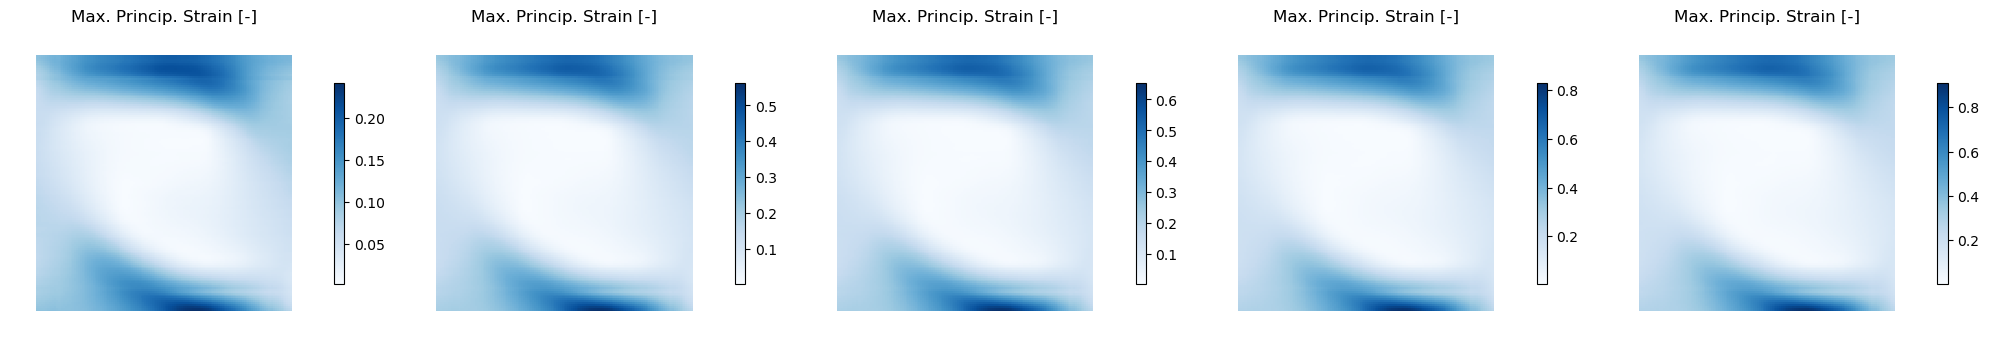

In [49]:
fig, axes = plt.subplots(1,5,figsize=(25,4))
strains = []
t_hist = np.arange(len(F_hist))
i = 0
for t, F in zip(t_hist, F_hist):
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T

    mps = np.maximum(E_11, E_22)
    if i%2==0:
        plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=axes[i//2], ec='None'); 
    i+= 1
    strains.append(np.array([t*np.ones(len(F)), F[:,0,0], F[:,0,1], F[:,1,0], F[:,1,1]]))
strains = np.hstack(strains)

### Coords_2_strain NN

In [52]:
# instead of using a 2D spline, use a NN to get the strain field for a given (x,y)
def loss_coords_2_strain(params, X, key):
    inp, out_gt = X[:,:3], X[:,3:] #inp: x,y,lmb and out_gt=eps_xx, eps_yy
    t = inp[:,2:3]
    out_pr = coords_2_strain_nn(inp, params)
    out_gt = out_gt/(t+1) #dividing by t+1 just for some regularization
    out_pr = out_pr/(t+1) #dividing by t+1 just for some regularization
    return jnp.mean((out_pr-out_gt)**2)

n_ff = 20 # 10 cosines and 10 sines in the fourier features
n_inp = 2 # x, y
ff_params = np.random.normal(size=n_inp*n_ff).reshape([n_inp,n_ff])*0.5
nn_layers = [2*n_ff+1,20,20,4]
nn_params = init_params_nn(nn_layers, key)
coord_2_strain_params = [ff_params, nn_params]

opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(coord_2_strain_params)

X = np.vstack([elem_X]*len(F_hist))
inp = np.hstack([X, strains.T])
coord_2_strain_params, train_loss, _ = train(loss_coords_2_strain, inp, get_params, opt_update, opt_state, key, nIter = 25000, print_freq=1000, batch_size=10000)

it 1000, train loss = 2.036761e-04
it 2000, train loss = 8.798617e-05
it 3000, train loss = 5.413688e-05
it 4000, train loss = 3.320152e-05
it 5000, train loss = 2.023921e-05
it 6000, train loss = 1.472306e-05
it 7000, train loss = 1.169531e-05
it 8000, train loss = 8.919637e-06
it 9000, train loss = 7.305159e-06
it 10000, train loss = 6.146186e-06
it 11000, train loss = 5.257314e-06
it 12000, train loss = 4.791732e-06
it 13000, train loss = 4.177776e-06
it 14000, train loss = 4.018998e-06
it 15000, train loss = 3.503475e-06
it 16000, train loss = 3.238358e-06
it 17000, train loss = 3.221258e-06
it 18000, train loss = 2.959295e-06
it 19000, train loss = 3.208954e-06
it 20000, train loss = 2.686764e-06
it 21000, train loss = 2.730584e-06
it 22000, train loss = 2.652658e-06
it 23000, train loss = 2.627043e-06
it 24000, train loss = 2.428948e-06
it 25000, train loss = 2.561064e-06


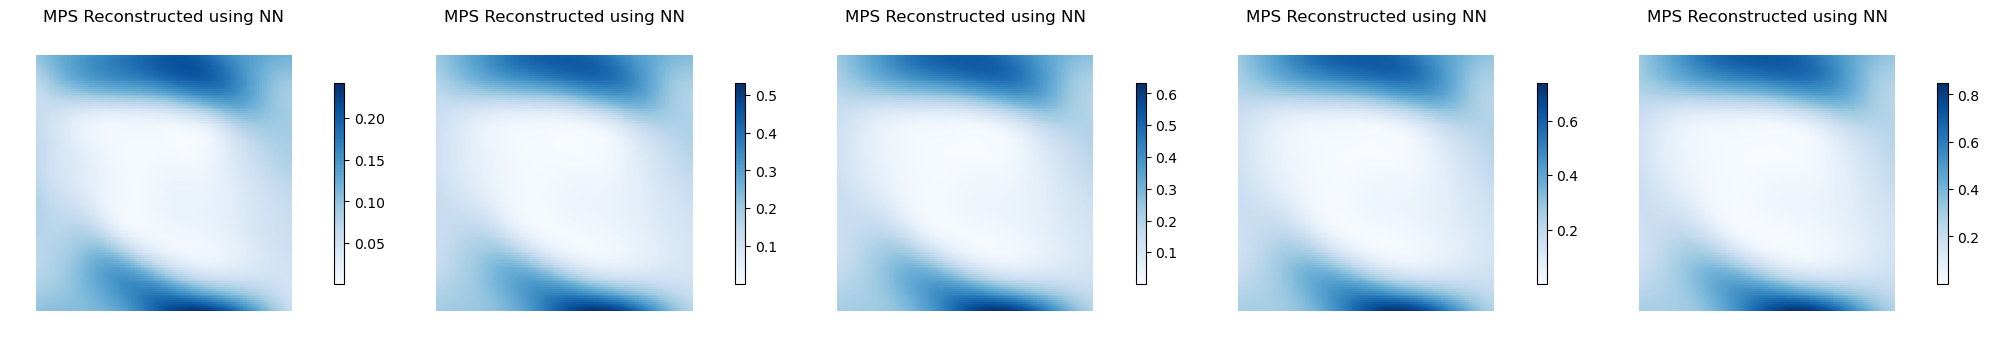

In [53]:
fig, axes = plt.subplots(1,5,figsize=(25,4))
for t in t_hist:
    aux = np.hstack([elem_X, t*np.ones_like(elem_X[:,:1])])
    F_xx, F_xy, F_yx, F_yy = coords_2_strain_nn(aux, coord_2_strain_params).T
    F = np.stack([F_xx, F_xy, F_yx, F_yy]).T.reshape([-1,2,2])
    
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T
    mps = np.maximum(E_11, E_22)

    if t%2==0:
        plotmesh(mesh.cells, mesh.points, mps, title='MPS Reconstructed using NN', ax=axes[t//2], ec='None'); 

In [54]:
# identify the boundaries
rgt_bd_elems = []
top_bd_elems = []
lft_bd_elems = []
bot_bd_elems = []
for i, e in enumerate(mesh.cells):
    if any([mesh.points[e[i],0]>0.99 for i in range(4)]):
        rgt_bd_elems.append(i)
    if any([mesh.points[e[i],1]>0.99 for i in range(4)]):
        top_bd_elems.append(i)
    if any([mesh.points[e[i],0]<0.01 for i in range(4)]):
        lft_bd_elems.append(i)
    if any([mesh.points[e[i],1]<0.01 for i in range(4)]):
        bot_bd_elems.append(i)

# get the reaction forces by integrating the stresses of the boundary elements
Force_x = [6.84936, 12.42992, 17.12095, 21.19064]
Force_y = [6.61385, 11.90493, 16.24685, 19.89937]
Force_x = np.interp(np.linspace(0,1,len(t_hist)), np.linspace(0,1,len(Force_x)), Force_x)
Force_y = np.interp(np.linspace(0,1,len(t_hist)), np.linspace(0,1,len(Force_y)), Force_y)

# get the center points of the elements
rgt_bd_X = elem_X[rgt_bd_elems]
top_bd_X = elem_X[top_bd_elems]
lft_bd_X = elem_X[lft_bd_elems]
bot_bd_X = elem_X[bot_bd_elems]
bd_X = rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X

In [55]:
Force_x = jnp.array(Force_x)
Force_y = jnp.array(Force_y)

In [57]:
# Homogenize the strains
F_xx_mean = np.mean(F_hist[:,:,0,0], axis=1)
F_xy_mean = np.mean(F_hist[:,:,0,1], axis=1)
F_yx_mean = np.mean(F_hist[:,:,1,0], axis=1)
F_yy_mean = np.mean(F_hist[:,:,1,1], axis=1)

P_xx_mean = Force_x/len(rgt_bd_elems)
P_yy_mean = Force_y/len(top_bd_elems)
inputs = np.array([F_xx_mean, F_xy_mean, F_yx_mean, F_yy_mean, P_xx_mean, P_yy_mean]).T

n_neurons = 4
# Define the loss function for when training all params
@jit
def loss_stress(params, x, key):
    model = NODE_model_aniso(params)
    F_xx, F_xy, F_yx, F_yy, P_xx_gt, P_yy_gt = x.T
    P = eval_P_vmap(F_xx, F_xy, F_yx, F_yy, model)
    P_xx_pr, P_yy_pr = P[:,0,0], P[:,1,1]
    return np.mean((P_xx_pr-P_xx_gt)**2+(P_yy_pr-P_yy_gt)**2)

# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, n_neurons, n_neurons]
sample_layers = [n_neurons,1]
node_params = init_params_aniso(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(node_params)

# Train
node_params, train_loss, _ = train(loss_stress, inputs, get_params, opt_update, opt_state, key, nIter = 50000, print_freq=1000)

it 1000, train loss = 1.476258e-03
it 2000, train loss = 4.892927e-04
it 3000, train loss = 3.930384e-04
it 4000, train loss = 3.002701e-04
it 5000, train loss = 1.839691e-04
it 6000, train loss = 5.681378e-05
it 7000, train loss = 2.287241e-05
it 8000, train loss = 2.102770e-05
it 9000, train loss = 2.095390e-05
it 10000, train loss = 2.086739e-05
it 11000, train loss = 2.075380e-05
it 12000, train loss = 2.063287e-05
it 13000, train loss = 2.054064e-05
it 14000, train loss = 2.048648e-05
it 15000, train loss = 2.045165e-05
it 16000, train loss = 2.041194e-05
it 17000, train loss = 2.034754e-05
it 18000, train loss = 2.024225e-05
it 19000, train loss = 2.007952e-05
it 20000, train loss = 1.987547e-05
it 21000, train loss = 1.968467e-05
it 22000, train loss = 1.952192e-05
it 23000, train loss = 1.943703e-05
it 24000, train loss = 1.939344e-05
it 25000, train loss = 1.936123e-05
it 26000, train loss = 1.933403e-05
it 27000, train loss = 1.930933e-05
it 28000, train loss = 1.928729e-05
i

In [58]:
mymodel = NODE_model_aniso(node_params)
P = eval_P_vmap(F_xx_mean, F_xy_mean, F_yx_mean, F_yy_mean, mymodel)
P_xx_pr, P_yy_pr = P[:,0,0], P[:,1,1]
print('gt P_xx & P_yy: ', P_xx_mean, P_yy_mean)
print('pr P_xx & P_yy: ', P_xx_pr, P_yy_pr)

gt P_xx & P_yy:  [0.025   0.03179 0.03858 0.04536 0.05107 0.05678 0.06249 0.06744 0.07239 0.07734] [0.02379 0.03014 0.03648 0.04282 0.04803 0.05324 0.05844 0.06282 0.0672  0.07158]
pr P_xx & P_yy:  [0.0185  0.03639 0.04261 0.04294 0.0497  0.05928 0.06427 0.06471 0.0711  0.07666] [0.01797 0.03427 0.03995 0.04031 0.04648 0.05539 0.06    0.06045 0.06637 0.07149]


In [59]:
# Fit a function Λ that maps x,y ∈ [0,1] to the individual-specific parameters of this NODE with a maximum variance of, say, 1%
phi, unravel = ravel_pytree(node_params)
n_phi = len(phi)

# ff_params = coord_2_strain_params[0]
# ff_nn2 = lambda x, nn_params: ff_nn(x, [ff_params, nn_params])
def loss_Lambda(params, inp, key):
    out_pr = ff_nn(inp, params)
    return jnp.mean((out_pr-phi)**2)

n_ff = 10
ff_params = np.random.normal(size=2*n_ff).reshape([2,n_ff])
nn_layers = [2*n_ff,40,40,n_phi]
nn_params = init_params_nn(nn_layers, key)
Lambda_params = [ff_params, nn_params]
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(Lambda_params)

inp = np.array(np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,20))).reshape([2,-1]).T
Lambda_params, train_loss, _ = train(loss_Lambda, inp, get_params, opt_update, opt_state, key, nIter = 5000, print_freq=1000)

it 1000, train loss = 1.733921e-04
it 2000, train loss = 7.604346e-05
it 3000, train loss = 3.881998e-05
it 4000, train loss = 2.096034e-05
it 5000, train loss = 1.173455e-05


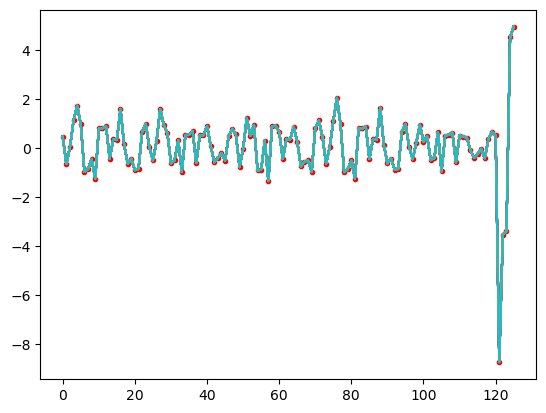

In [60]:
fig, ax = plt.subplots()
ax.plot(phi, 'r.-')
for y in np.linspace(0,1,4):
    for x in np.linspace(0,1,10):
        params = ff_nn(np.array([x,y]).reshape([1,-1]), Lambda_params)
        ax.plot(params[0])

In [61]:
with open('params/AM_S_pre.npy', 'wb') as f:
    pickle.dump([coord_2_strain_params, node_params, Lambda_params, mesh, elem_X, Force_x, Force_y, strains,
                 bd_X, F_hist, t_hist], f)

## 2. Retrain

In [17]:
with open('params/AM_S_pre.npy', 'rb') as f:
    coord_2_strain_params, node_params, Lambda_params, mesh, elem_X, Force_x, Force_y, strains, \
                 bd_X, F_hist, t_hist = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

In [20]:
@partial(jit, static_argnums=(0,2,3,))
def step_colloc(loss, i, get_params, opt_update, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch)
    return opt_update(i, g, opt_state)

def train_colloc(loss, inp, get_params, opt_update, opt_state, key, sharding, nIter = 10000, print_freq=1000, metric_fns=None, batch_size=10000, lr = 1e-4):
    node_X, t_hist = inp
    node_X_ext = jnp.hstack([node_X, t_hist[-1]*np.ones_like(node_X[:,:1])]) #append a row consisting of t_hist[-1]
    val_loss = []
    metrics = []
    prev = 0
    for it in range(nIter):
        key, subkey = random.split(key)
        XY_colloc = random.uniform(key, (batch_size,2))
        t_colloc = random.choice(key, t_hist, (batch_size,1))
        XYt_colloc = jnp.hstack([XY_colloc, t_colloc])
        XYt_colloc = jax.device_put(XYt_colloc, sharding)
        opt_state = step_colloc(loss, it, get_params, opt_update, opt_state, XYt_colloc)

        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            val_loss_value = loss(params, node_X_ext)
            val_loss.append(val_loss_value)
            if metric_fns is not None:
                m = []
                for metric_fn in metric_fns:
                    m.append(metric_fn(params, node_X_ext))
                metrics.append(m)
            to_print = "it {}, val loss = {:e}".format(it+1, val_loss_value)
            print(to_print)
    return get_params(opt_state), val_loss, metrics

In [21]:
# Train
a1 = 10000
@jit
def loss(Lambda_params, XYt_colloc):
    Div_x, Div_y = divergence(Lambda_params, XYt_colloc, coord_2_strain_params, NODE_w_unravel)
    loss_Div = a1*(Div_x**2 + Div_y**2)

    def bd_forces_loss(_, t):
        F_rgt, F_top, F_lft, F_bot = bd_forces(Lambda_params, t, bd_X, coord_2_strain_params, NODE_w_unravel)
        Fx = Force_x[jnp.array(t, int)]
        Fy = Force_y[jnp.array(t, int)]
        return None, a2*((F_rgt-Fx)**2 + (F_top-Fy)**2 + (F_lft-Fx)**2 + (F_bot-Fy)**2)
    loss_F = jnp.mean(scan(bd_forces_loss, init=None, xs=t_hist)[1])
    # loss_F = 0.0
    
    return loss_Div + loss_F

# lr = 1e-4
lr = optimizers.exponential_decay(1e-4, 1000, 0.9)
sharding = PositionalSharding(jax.devices()).reshape(n_cores, 1)
opt_init, opt_update, get_params = optimizers.adam(lr) 
opt_state = opt_init(Lambda_params)

node_X_ext = jnp.hstack([mesh.points, t_hist[-1]*np.ones_like(mesh.points[:,:1])])
metric1 = lambda params, X:  bd_forces(params, t_hist[-1], bd_X, coord_2_strain_params, NODE_w_unravel)
metric2 = lambda params, X: divergence(params, node_X_ext, coord_2_strain_params, NODE_w_unravel)

Lambda_params, val_loss, metrics = train_colloc(loss, [mesh.points, t_hist], get_params, opt_update, opt_state, 
                                            key, sharding, nIter = 75000, print_freq=1000, batch_size=1000, lr = lr)

with open('params/AM_S_post.npy', 'wb') as f:
    pickle.dump([mesh, elem_X, strains, Force_x, Force_y, node_params, Lambda_params, val_loss, metrics, t_hist], f)

Iteration  501 Learning rate =  7.500000000000001e-05
it 1000, val loss = 1.140035e+01
Iteration  1001 Learning rate =  5.6250000000000005e-05
it 2000, val loss = 2.085435e+00
Iteration  2001 Learning rate =  4.21875e-05
it 3000, val loss = 1.720185e+00
it 4000, val loss = 1.576522e+00
it 5000, val loss = 1.544444e+00
Iteration  5001 Learning rate =  3.1640625e-05
it 6000, val loss = 1.498742e+00
it 7000, val loss = 1.438109e+00
it 8000, val loss = 1.386608e+00
it 9000, val loss = 1.395855e+00
it 10000, val loss = 1.293909e+00
Iteration  10001 Learning rate =  2.373046875e-05
it 11000, val loss = 1.280924e+00
it 12000, val loss = 1.236246e+00
it 13000, val loss = 1.225759e+00
it 14000, val loss = 1.220178e+00
it 15000, val loss = 1.233160e+00
Iteration  15001 Learning rate =  1.7797851562499998e-05
it 16000, val loss = 1.277272e+00
it 17000, val loss = 1.212956e+00
it 18000, val loss = 1.210025e+00
it 19000, val loss = 1.195073e+00
it 20000, val loss = 1.212075e+00
Iteration  20001 Lea

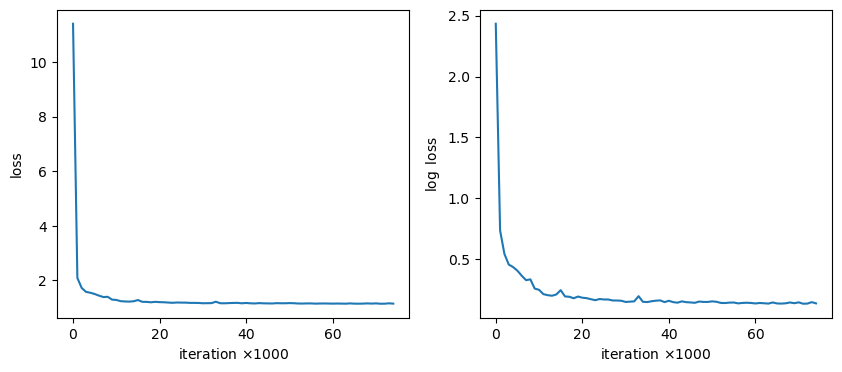

In [22]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(val_loss)
ax[1].plot(np.log(val_loss))

ax[0].set(xlabel='iteration $\\times 1000$', ylabel='loss')
ax[1].set(xlabel='iteration $\\times 1000$', ylabel='$\log$ loss'); 

## 3. Test

In [23]:
with open('params/AM_S_post.npy', 'rb') as f:
    mesh, elem_X, strains, Force_x, Force_y, node_params, Lambda_params, val_loss, metrics, t_hist = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

In [24]:
cell_type = get_meshio_cell_type('QUAD4')

Nx, Ny = 50, 50
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh2 = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])
elem_X2 = mesh2.points[mesh2.cells].mean(axis=1)

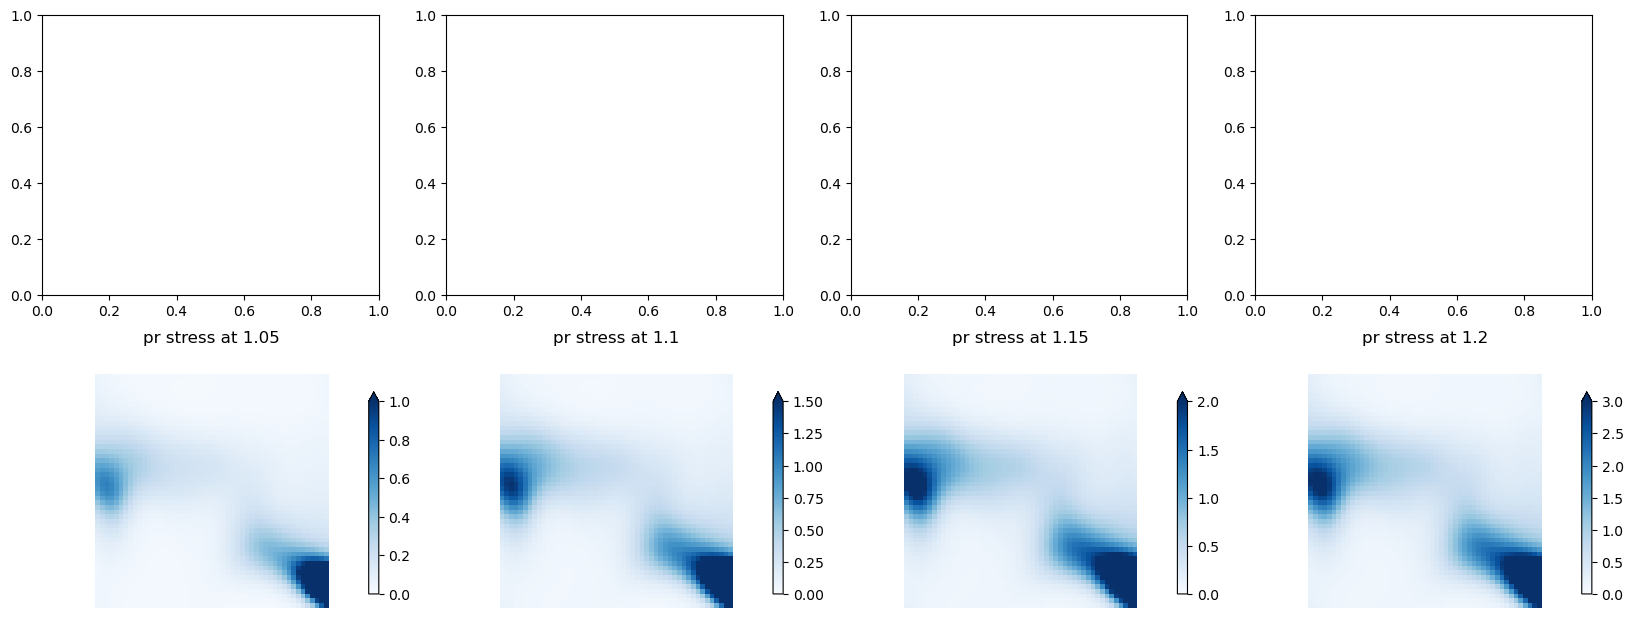

In [26]:
# Stiffness across the domain
fig, axes = plt.subplots(2,4,figsize=(20,8))
lmb_hist = [1.05, 1.1, 1.15, 1.2]

extents = [[0.0, 1.0],
           [0.0, 1.5],
           [0.0, 2.0],
           [0.0, 3.0]]
for lmb, ax, extent in zip(lmb_hist, axes.T, extents):
    ugrad = jnp.array([[lmb-1.0, 0.0], [0.0, lmb-1.0]])

    # params_gt = []
    # for xy in elem_X:
    #     params_gt.append(coords_2_params_gt(xy))
    # params_gt = np.array(params_gt)
    params_pr = ff_nn(elem_X2, Lambda_params)

    # c_elem_gt = []
    c_elem_pr = []
    # for params_gt_i, params_pr_i in zip(params_gt, params_pr):
    for params_pr_i in params_pr:
        # c_elem_gt.append(ThreeDElasticity(GOH_model).ugrad_2_P(ugrad, params_gt_i, 2)[0,0])
        c_elem_pr.append(ThreeDElasticity(NODE_w_unravel).ugrad_2_P(ugrad, params_pr_i, 2)[0,0])
    
    # plotmesh(mesh.cells, mesh.points, c_elem_gt, title='gt stress at {}'.format(str(lmb)), ax=ax[0]); 
    # extent = [np.min(c_elem_gt), np.max(c_elem_gt)]
    # if extent[0] > np.min(c_elem_pr) and extent[1] < np.max(c_elem_pr):
    #     extend='both'
    # elif extent[0] > np.min(c_elem_pr):
    #     extend='min'
    # elif extent[1] < np.max(c_elem_pr):
    #     extend='max'
    plotmesh(mesh2.cells, mesh2.points, c_elem_pr, title='pr stress at {}'.format(str(lmb)), ax=ax[1], ec='None', extent=extent, extend='max'); 

In [4]:
P_vmap = vmap(ThreeDElasticity(NODE_w_unravel).ugrad_2_P, in_axes=(0, 0, None))
class HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: ThreeDElasticity(NODE_w_unravel).ugrad_2_P(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [5]:
params_vec = []
for x, y in elem_X:
    Lambda_inp = np.array([x,y]).reshape([-1,2])
    phi = ff_nn(Lambda_inp, Lambda_params).flatten()
    params_vec.append(phi)
params_vec = jnp.array(params_vec).reshape([len(params_vec),1,-1])
params_vec = jnp.repeat(params_vec, axis=1, repeats=4)

In [6]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.05, 1.10, 1.15, 1.20]
n_elem = Nx*Ny
C10 = jnp.zeros(n_elem)
k1  = jnp.zeros(n_elem)
k2  = jnp.zeros(n_elem)
F_hist = []
node_x_hist = []
P_hist = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    P = P_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist.append(F)
    node_x_hist.append(node_x)
    P_hist.append(P)
node_x_hist = np.array(node_x_hist)
F_hist = np.array(F_hist)
P_hist = np.array(P_hist)

[01-29 12:02:18][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[01-29 12:02:18][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[01-29 12:02:18][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[01-29 12:02:19][DEBUG] jax_fem: Done pre-computations, took 0.3462047576904297 [s]
[01-29 12:02:19][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[01-29 12:02:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-29 12:02:19][DEBUG] jax_fem: Start timing
[01-29 12:02:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-29 12:02:22][DEBUG] jax_fem: Function split_and_compute_cell took 2.7130 seconds
[01-29 12:02:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-29 12:02:22][DEBUG] jax_fem: Linear guess solve...
[01-29 12:02:22][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[01-29 12:02:22][DEBUG] jax_fem: PETSc 

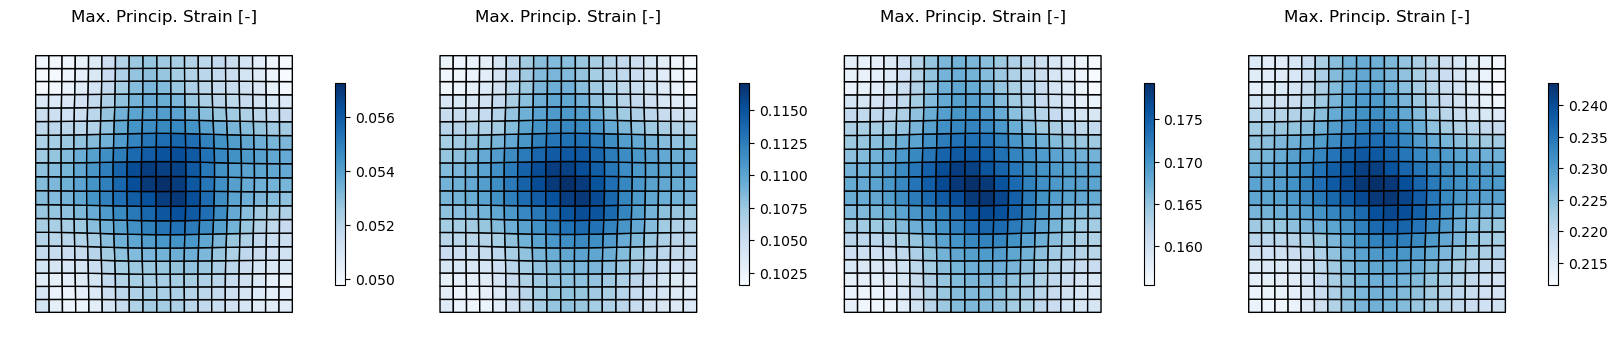

In [8]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
t_hist = np.arange(len(lmb_hist))
for t, node_x, F, ax in zip(t_hist, node_x_hist, F_hist, axes):
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T

    mps = np.maximum(E_11, E_22)
    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 